# Using Python With Quandl Data

### Preliminaries

We want plots to appear in this notebook rather than in a separate window.

In [1]:
%matplotlib inline

Import Python modules to support our research.  If you are using _Anaconda_ then you may need to run _conda install seaborn_ and similar commands.

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import quandl
import functools
import seaborn as sns
import plotnine as p9

### Load the Data


We are likely to run this notebook over and over, so we add memoizaiton to the data loading function. This makes testing and re-running our code far faster, and even lets us work offline.  Note that if we change the code inside our function, we may get unexpectedly stale results out of the cache!

In [3]:
try:
    # Do not recreate if it already exists
    fetch_quandl
    print("fetch_quandl already defined")
except NameError:
    @functools.lru_cache(maxsize=16)
    def fetch_quandl(my_securities):
        print("Fetching from Quandl")
        qdata = quandl.get(list(my_securities), returns="pandas",
                          api_key=BrianBoonstraPrivateKeys['Quandl'],
                          start_date='1985-01-02', end_date='2018-03-02')
        return qdata
    print("fetch_quandl has now been newly defined")

fetch_quandl has now been newly defined


In [4]:
raw_data = fetch_quandl(('WIKI/XOM', "NSE/OIL"))


Fetching from Quandl


### See what we downloaded

In [5]:
raw_data.tail()

,WIKI/XOM - Open,WIKI/XOM - High,WIKI/XOM - Low,WIKI/XOM - Close,WIKI/XOM - Volume,WIKI/XOM - Ex-Dividend,WIKI/XOM - Split Ratio,WIKI/XOM - Adj. Open,WIKI/XOM - Adj. High,WIKI/XOM - Adj. Low,WIKI/XOM - Adj. Close,WIKI/XOM - Adj. Volume,NSE/OIL - Open,NSE/OIL - High,NSE/OIL - Low,NSE/OIL - Last,NSE/OIL - Close,NSE/OIL - Total Trade Quantity,NSE/OIL - Turnover (Lacs)
Date,,,,,,,,,,,,,,,,,,,
2018-02-26,77.74,78.9300,77.560,78.84,16733474.0,0.0,1.0,77.74,78.9300,77.560,78.84,16733474.0,348.65,352.00,346.85,348.70,348.95,401920.0,1402.02
2018-02-27,79.00,79.8700,77.500,77.50,14420126.0,0.0,1.0,79.00,79.8700,77.500,77.50,14420126.0,351.00,354.20,346.70,348.35,349.15,394689.0,1384.82
2018-02-28,78.16,78.2500,75.700,75.74,16453545.0,0.0,1.0,78.16,78.2500,75.700,75.74,16453545.0,347.00,350.35,345.50,349.50,349.85,409813.0,1427.33
2018-03-01,75.53,76.6808,74.855,75.20,15696665.0,0.0,1.0,75.53,76.6808,74.855,75.20,15696665.0,349.45,351.80,345.05,349.55,349.75,339238.0,1184.83
2018-03-02,74.89,75.8700,74.480,75.55,15630250.0,0.0,1.0,74.89,75.8700,74.480,75.55,15630250.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


It needs cleaning!

### Common Quant Task: Massaging The Data

Here we create a function that cleans up column names in our data, for better-looking plot labels and plot specifications

In [6]:
def clean_quandl_columns(dataframe):
    replacement_columns = {}
    for c in dataframe.columns:
        series_name, variable = c.split(' - ')
        source_name, asset = series_name.split('/')
        replacement_columns[c] = asset+":"+variable
    renamed_data = dataframe.rename(columns=replacement_columns)
    return renamed_data
renamed_data = clean_quandl_columns(raw_data)
renamed_data.tail()


,XOM:Open,XOM:High,XOM:Low,XOM:Close,XOM:Volume,XOM:Ex-Dividend,XOM:Split Ratio,XOM:Adj. Open,XOM:Adj. High,XOM:Adj. Low,XOM:Adj. Close,XOM:Adj. Volume,OIL:Open,OIL:High,OIL:Low,OIL:Last,OIL:Close,OIL:Total Trade Quantity,OIL:Turnover (Lacs)
Date,,,,,,,,,,,,,,,,,,,
2018-02-26,77.74,78.9300,77.560,78.84,16733474.0,0.0,1.0,77.74,78.9300,77.560,78.84,16733474.0,348.65,352.00,346.85,348.70,348.95,401920.0,1402.02
2018-02-27,79.00,79.8700,77.500,77.50,14420126.0,0.0,1.0,79.00,79.8700,77.500,77.50,14420126.0,351.00,354.20,346.70,348.35,349.15,394689.0,1384.82
2018-02-28,78.16,78.2500,75.700,75.74,16453545.0,0.0,1.0,78.16,78.2500,75.700,75.74,16453545.0,347.00,350.35,345.50,349.50,349.85,409813.0,1427.33
2018-03-01,75.53,76.6808,74.855,75.20,15696665.0,0.0,1.0,75.53,76.6808,74.855,75.20,15696665.0,349.45,351.80,345.05,349.55,349.75,339238.0,1184.83
2018-03-02,74.89,75.8700,74.480,75.55,15630250.0,0.0,1.0,74.89,75.8700,74.480,75.55,15630250.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
renamed_data[["XOM:Adj. Close","OIL:Close"]].dropna().tail()

,XOM:Adj. Close,OIL:Close
Date,,
2018-02-23,77.53,344.50
2018-02-26,78.84,348.95
2018-02-27,77.50,349.15
2018-02-28,75.74,349.85
2018-03-01,75.20,349.75


Now it looks better!

### Examining The Data

/Volumes/b2tb/conda_envs/2021-Apr-33150/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0.98, 'Oil and an Oil Firm, 1970-2015')

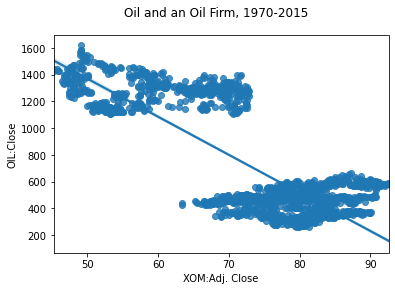

In [8]:
fig, ax = plt.subplots()
splot = sns.regplot("XOM:Adj. Close","OIL:Close",data=renamed_data, ax=ax)
fig.suptitle('Oil and an Oil Firm, 1970-2015')

Time series plots can tell us more about what happened

/Volumes/b2tb/conda_envs/2021-Apr-33150/lib/python3.7/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 73 rows containing missing values.
/Volumes/b2tb/conda_envs/2021-Apr-33150/lib/python3.7/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 6342 rows containing missing values.


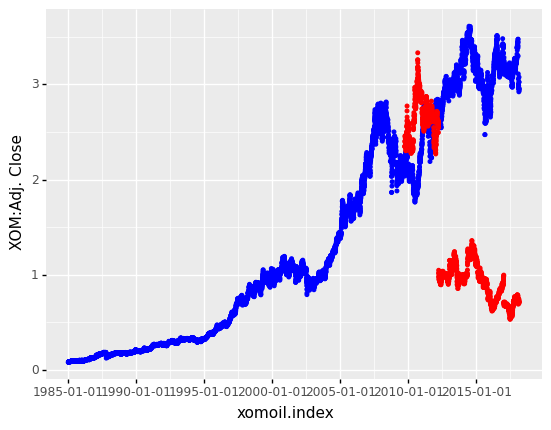

<ggplot: (8762187645621)>

In [15]:
xomoil = renamed_data[["XOM:Adj. Close", "OIL:Close"]]
xomoil = xomoil / xomoil.median(axis=0)

(
    p9.ggplot(xomoil)
    + p9.geom_point(mapping=p9.aes(x='xomoil.index', y="XOM:Adj. Close"), color='blue', size=1)
    + p9.geom_point(mapping=p9.aes(x='xomoil.index', y="OIL:Close"), color='red', size=1)
)